In [2]:
import torch
# Assuming you're using a CUDA-enabled GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
np.bool8 = np.bool_
import pandas as pd
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

### CartPole Env
- Policy Network
- Value Network
- Select Action
- Discount Reward

In [8]:
# Hyperparameters
GAMMA = 0.95  # Discount factor
LEARNING_RATE = 0.01
EPISODES = 800
HIDDEN_SIZE = 128

# Create the CartPole environment
env = gym.make('CartPole-v1')

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Policy Network (Simple Neural Network)
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)  # Softmax for probability distribution over actions
        return x

# Value Network for value-based baseline
class ValueNetwork(nn.Module):
    def __init__(self, state_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 1)  # Output is a single value representing V(s)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation function because we want raw value
        return x
    
# Update the select_action function to handle the state tuple and use GPU
def select_action(policy_net, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Extract and send to GPU
    probs = policy_net(state).detach().cpu().numpy()  # Get action probabilities, move back to CPU
    action = np.random.choice(len(probs[0]), p=probs[0])  # Sample action
    return action

# Discounted reward function
def discount_rewards(rewards, gamma):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    cumulative_reward = 0
    for t in reversed(range(len(rewards))):
        cumulative_reward = rewards[t] + gamma * cumulative_reward
        discounted_rewards[t] = cumulative_reward
    return discounted_rewards

# Function to train the model
def train(baseline_type = "value"):
    state_size = env.observation_space.shape[0]  # 4 for CartPole
    action_size = env.action_space.n  # 2 actions (left or right)
    
    policy_net = PolicyNetwork(state_size, action_size).to(device)  # Initialize the policy network
    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    
    # Initialize value network and optimizer only if we're using a value-based baseline
    if baseline_type == 'value':
        value_net = ValueNetwork(state_size).to(device)
        optimizer_value = optim.Adam(value_net.parameters(), lr=0.01)
    
    # Lists to keep track of episode rewards and moving averages
    episode_rewards = []
    moving_average_rewards = []
    reward_deque = deque(maxlen=100)  # For calculating the moving average over 100 episodes
    
    for episode in range(EPISODES):
        state, _ = env.reset()  # Updated to handle new reset() return format
        log_probs = []
        rewards = []
        state_values = []  # To store value estimates for each state
        
        
        done = False
        while not done:
            action = select_action(policy_net, state)
            next_state, reward, terminated, truncated, _ = env.step(action)  # Updated to handle 5 return values
            
            log_prob = torch.log(policy_net(torch.from_numpy(state).float().unsqueeze(0).to(device))[0][action])
            log_probs.append(log_prob)
            rewards.append(reward)

            # If using value baseline, calculate state value
            if baseline_type == 'value':
                state_value = value_net(torch.from_numpy(state).float().unsqueeze(0).to(device))  # Move state to GPU
                state_values.append(state_value)
            
            state = next_state
            done = terminated or truncated
        
        # Calculate discounted rewards
        discounted_rewards = discount_rewards(rewards, GAMMA)
        discounted_rewards = torch.tensor(discounted_rewards).to(device)
        
        # Policy Gradient Update
        optimizer.zero_grad()
        policy_gradient = []
        
        if baseline_type == 'value':
            # If using value baseline, calculate advantages
            advantages = (discounted_rewards - torch.cat(state_values).squeeze().to(device))
        else:
            # No baseline, use discounted rewards directly as advantages
            advantages = discounted_rewards.to(device)

        # Normalize the advantages
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)
        
        # Calculate policy gradients
        for log_prob, advantage in zip(log_probs, advantages):
            policy_gradient.append(-log_prob * advantage)
        policy_gradient = torch.stack(policy_gradient).sum()
        
        policy_gradient.backward(retain_graph=True)
        optimizer.step()
        
        # Update value network (if using baseline)
        if baseline_type == 'value':
            optimizer_value.zero_grad()
            value_loss = nn.MSELoss()(torch.cat(state_values).squeeze(), discounted_rewards)
            value_loss.backward()
            optimizer_value.step()
        
        episode_total_reward = sum(rewards)
        episode_rewards.append(episode_total_reward)
        reward_deque.append(episode_total_reward)
        moving_average_rewards.append(np.mean(reward_deque))
        
        
        if episode % 100 == 0:
            print(f'Episode {episode}, Total Reward: {episode_total_reward},Moving Average: {np.mean(reward_deque)}')
        
    
    # Plot Episode Rewards and Moving Average
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Episode Rewards')
    plt.plot(moving_average_rewards, label='100-Episode Moving Average')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()
    
    return policy_net

# Roll out the trained policy for 500 episodes and plot the histogram
def evaluate(policy_net, episodes=500):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()  # Updated to handle new reset() return format
        episode_reward = 0
        done = False
        while not done:
            action = select_action(policy_net, state)
            state, reward, terminated, truncated, _ = env.step(action)  # Updated to handle new step() return format
            done = terminated or truncated
            episode_reward += reward
        rewards.append(episode_reward)
    
    rewards = np.array(rewards)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Print mean and standard deviation
    print(f"Mean Reward: {mean_reward}, Standard Deviation: {std_reward}")
    
    # Plot histogram of rewards
    plt.figure(figsize=(10, 5))
    plt.hist(rewards, bins=20, edgecolor='black')
    plt.title('Histogram of Rewards Over 500 Episodes')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.show()


Episode 0, Total Reward: 12.0,Moving Average: 12.0
Episode 100, Total Reward: 184.0,Moving Average: 115.24
Episode 200, Total Reward: 134.0,Moving Average: 163.2
Episode 300, Total Reward: 226.0,Moving Average: 301.8
Episode 400, Total Reward: 276.0,Moving Average: 384.1
Episode 500, Total Reward: 174.0,Moving Average: 436.56
Episode 600, Total Reward: 120.0,Moving Average: 116.13
Episode 700, Total Reward: 21.0,Moving Average: 110.99


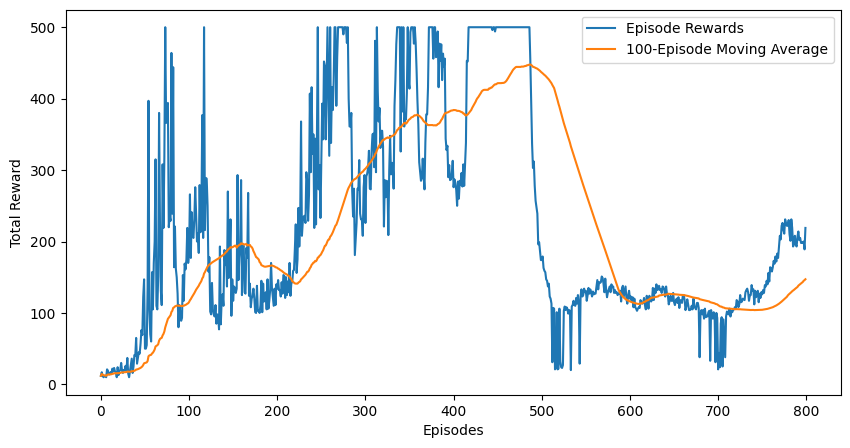

In [6]:
# Train the policy gradient model
no_baseline_cart = train(baseline_type = "none")

Mean Reward: 204.702, Standard Deviation: 9.475716120695047


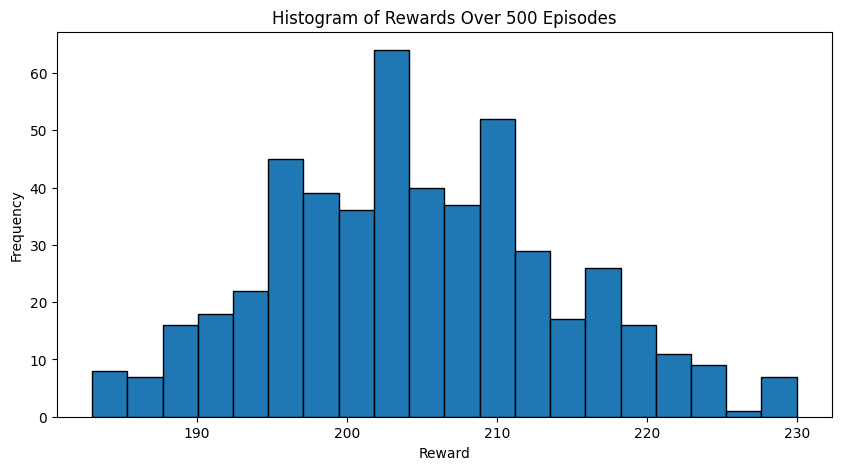

In [9]:
# Evaluate the trained policy
evaluate(no_baseline_cart)

Episode 0, Total Reward: 52.0,Moving Average: 52.0
Episode 100, Total Reward: 100.0,Moving Average: 75.7
Episode 200, Total Reward: 116.0,Moving Average: 149.23
Episode 300, Total Reward: 108.0,Moving Average: 122.67
Episode 400, Total Reward: 111.0,Moving Average: 108.2
Episode 500, Total Reward: 112.0,Moving Average: 80.18
Episode 600, Total Reward: 299.0,Moving Average: 135.77
Episode 700, Total Reward: 500.0,Moving Average: 181.2


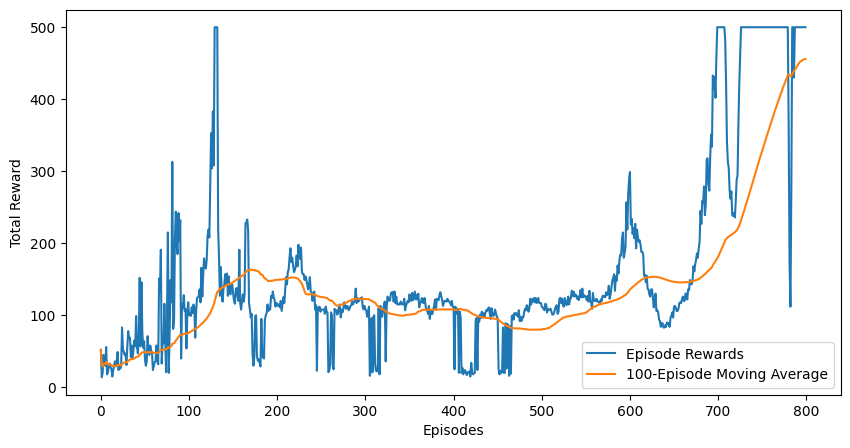

In [10]:
baseline_cart = train(baseline_type = "value")

Mean Reward: 500.0, Standard Deviation: 0.0


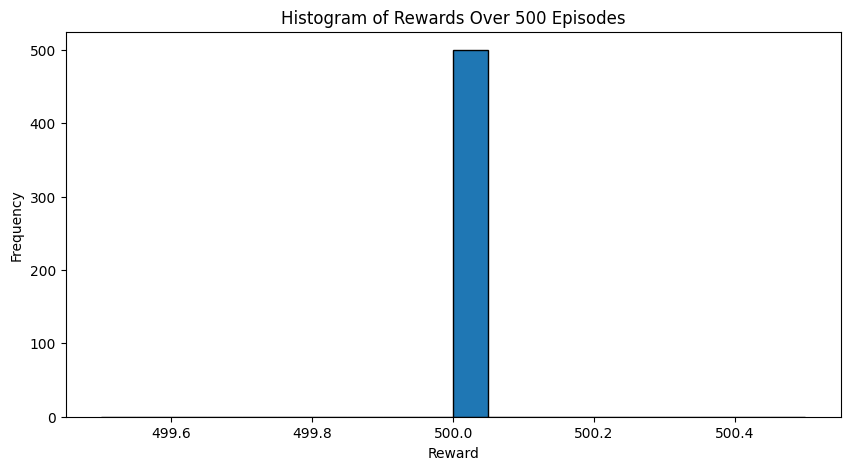

In [12]:
# Evaluate the trained policy
evaluate(baseline_cart)

## Visualization of the cartpole environment using the trained policy

Episode 3 finished after 500 steps. Total reward: 500.0


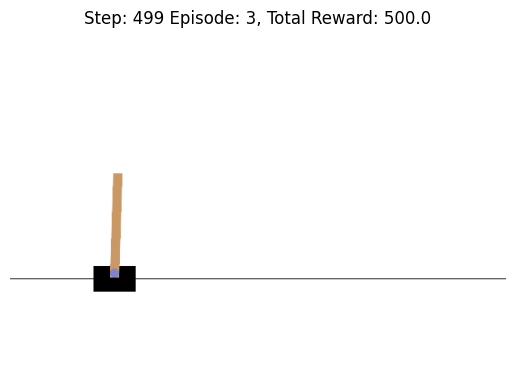

In [5]:
import gym
import numpy as np
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.axis('off')
    plt.title(f"Step: {step} {info}")
    display.display(plt.gcf())
    display.clear_output(wait=True)

def evaluate_and_visualize(policy_net, num_episodes=3, max_steps=500):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        step = 0
        total_reward = 0
        done = False
        
        while not done and step < max_steps:
            # Select action
            action = select_action(policy_net, state)
            
            # Take action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            # Visualize the current state
            show_state(env, step, f"Episode: {episode+1}, Total Reward: {total_reward}")
            
            step += 1
        
        print(f"Episode {episode+1} finished after {step} steps. Total reward: {total_reward}")
    
    env.close()
    
evaluate_and_visualize(trained_policy)

### Pong Env
- Preprocess Image
- Policy Network
- Value Network
- Select Action
- Discount Reward
- Train with 400 episodes with learning rate for both optimizer 0.001

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Preprocessing function as you provided
def preprocess(image):
    """ Preprocess 210x160x3 uint8 frame into 80x80 2D float array """
    image = image[35:195]  # crop
    image = image[::2, ::2, 0]  # downsample by factor of 2
    image[image == 144] = 0  # erase background (background type 1)
    image[image == 109] = 0  # erase background (background type 2)
    image[image != 0] = 1  # paddles and ball set to 1
    return np.reshape(image.astype(np.float32).ravel(), [80, 80])

# Neural network for image input
# Fully connected layer calculation: (Input_size - kernel_size) / stride + 1, so (80 - 8) / 4 + 1 = 19
# for the second layer, (19 - 5) / 2 + 1 = 8
class PolicyNetwork(nn.Module):
   
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(80*80, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.softmax(self.fc3(x).clamp(min=1e-10, max=1-1e-10), dim=-1)# Softmax for action probabilities
        return x

# Value Network for value-based baseline
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(80*80, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)  # Output is a single value representing V(s)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function because we want raw value
        return x
    
# Convert image to tensor and add batch dimension
def preprocess_image(image):
    image = preprocess(image)  # Preprocess the raw image
    image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions
    return image

# Choose action based on policy probabilities
def select_action(policy_net, state):
    state = preprocess_image(state).to(device)
    probs = policy_net(state).detach().cpu().numpy()  # Get action probabilities
    action = np.random.choice(len(probs[0]), p=probs[0])  # Sample action
    return action

# Discounted reward function
def discount_rewards(rewards, gamma=0.99):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    cumulative_reward = 0
    for t in reversed(range(len(rewards))):
        cumulative_reward = rewards[t] + gamma * cumulative_reward
        discounted_rewards[t] = cumulative_reward
    return discounted_rewards

# Training function with baseline or no baseline
def train_pong(baseline_type='value'):  # 'value' for value baseline, 'none' for no baseline
    env = gym.make('ALE/Pong-v5')
    policy_net = PolicyNetwork().to(device)
    optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.001)

    # Initialize value network and optimizer only if we're using a value-based baseline
    if baseline_type == 'value':
        value_net = ValueNetwork().to(device)
        optimizer_value = optim.Adam(value_net.parameters(), lr=0.001)
    
    EPISODES = 400
    
    # Lists to keep track of episode rewards and moving averages
    episode_rewards = []
    moving_average_rewards = []
    reward_deque = deque(maxlen=100)  # For calculating the moving average over 100 episodes
    
    for episode in range(EPISODES):
        state,_ = env.reset()
        log_probs = []
        rewards = []
        state_values = []  # To store value estimates for each state
        
        done = False
        while not done:
            action = select_action(policy_net, state)
            next_state, reward, terminated, truncated, info = env.step(action + 3)  # Action offset for Pong
            
            log_prob = torch.log(policy_net(preprocess_image(state)).to(device)[0][action] + 1e-10) # add a epsilon to avoid taking log of 0.
            log_probs.append(log_prob)
            rewards.append(reward)

            # If using value baseline, calculate state value
            if baseline_type == 'value':
                state_value = value_net(preprocess_image(state).to(device))
                state_values.append(state_value)
            
            state = next_state
            done = terminated or truncated
        
        # Calculate discounted rewards
        discounted_rewards = discount_rewards(rewards)
        discounted_rewards = torch.tensor(discounted_rewards).to(device)
        
        # Policy Gradient Update
        optimizer_policy.zero_grad()
        policy_gradient = []
        
        if baseline_type == 'value':
            # If using value baseline, calculate advantages
            advantages = (discounted_rewards - torch.cat(state_values).squeeze()).to(device)
        else:
            # No baseline, use discounted rewards directly as advantages
            advantages = discounted_rewards.to(device)

        # Normalize the advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)
        
        # Calculate policy gradients
        for log_prob, advantage in zip(log_probs, advantages):
            policy_gradient.append(-log_prob * advantage)
        policy_gradient = torch.stack(policy_gradient).sum()
        
        policy_gradient.backward(retain_graph=True)
        optimizer_policy.step()
        
        # Update value network (if using baseline)
        if baseline_type == 'value':
            optimizer_value.zero_grad()
            value_loss = nn.MSELoss()(torch.cat(state_values).squeeze(), discounted_rewards)
            value_loss.backward()
            optimizer_value.step()
        
        episode_total_reward = sum(rewards)
        episode_rewards.append(episode_total_reward)
        reward_deque.append(episode_total_reward)
        moving_average_rewards.append(np.mean(reward_deque))
        
        
        if episode % 100 == 0:
            print(f'Episode {episode}, Total Reward: {episode_total_reward}')
    
    # Plot Episode Rewards and Moving Average
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label='Episode Rewards')
    plt.plot(moving_average_rewards, label='100-Episode Moving Average')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()
    
    return policy_net


Episode 0, Total Reward: -20.0
Episode 100, Total Reward: -21.0
Episode 200, Total Reward: -21.0
Episode 300, Total Reward: -19.0


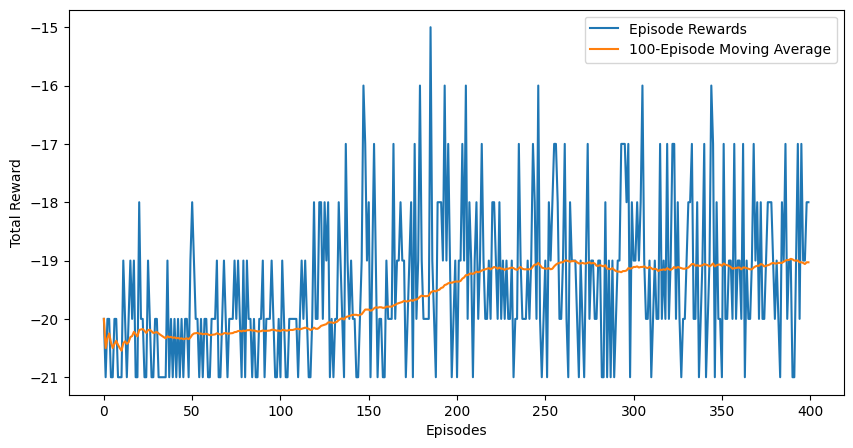

In [6]:
# Train using value-based baseline
pong_no_baseline = train_pong(baseline_type='none')

In [4]:
# Roll out the trained policy for 500 episodes and plot the histogram
def evaluate(policy_net, episodes=500):
    rewards = []
    env = gym.make('ALE/Pong-v5')
    for _ in range(episodes):
        state, _ = env.reset()  # Updated to handle new reset() return format
        episode_reward = 0
        done = False
        while not done:
            action = select_action(policy_net, state)
            state, reward, terminated, truncated, _ = env.step(action + 3)  # Updated to handle new step() return format
            done = terminated or truncated
            episode_reward += reward
        rewards.append(episode_reward)
    
    rewards = np.array(rewards)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Print mean and standard deviation
    print(f"Mean Reward: {mean_reward}, Standard Deviation: {std_reward}")
    
    # Plot histogram of rewards
    plt.figure(figsize=(10, 5))
    plt.hist(rewards, bins=20, edgecolor='black')
    plt.title('Histogram of Rewards Over 500 Episodes')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.show()



Mean Reward: -19.082, Standard Deviation: 1.3795926935150098


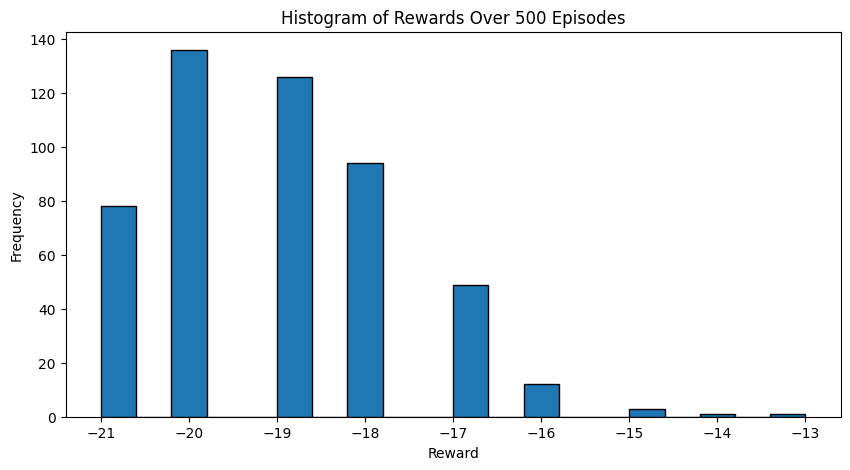

In [8]:
# Evaluate the trained policy
evaluate(pong_no_baseline)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Episode 0, Total Reward: -20.0
Episode 100, Total Reward: -21.0
Episode 200, Total Reward: -19.0
Episode 300, Total Reward: -20.0


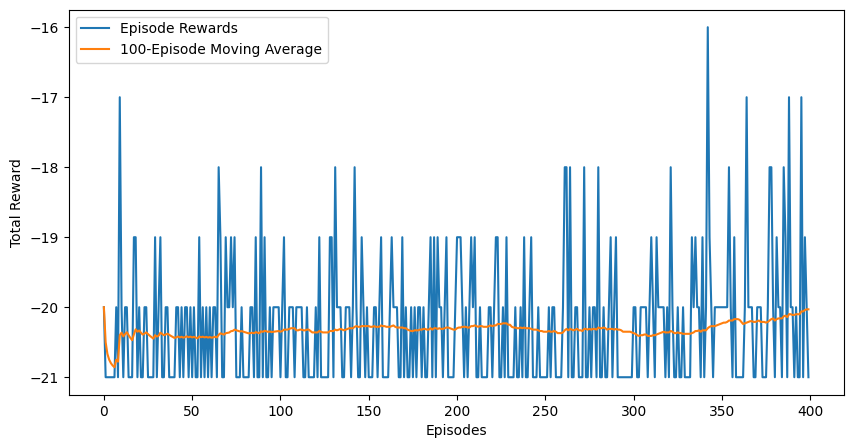

In [5]:
pong_baseline = train_pong(baseline_type = "value")

Mean Reward: -20.262, Standard Deviation: 0.8656535103608141


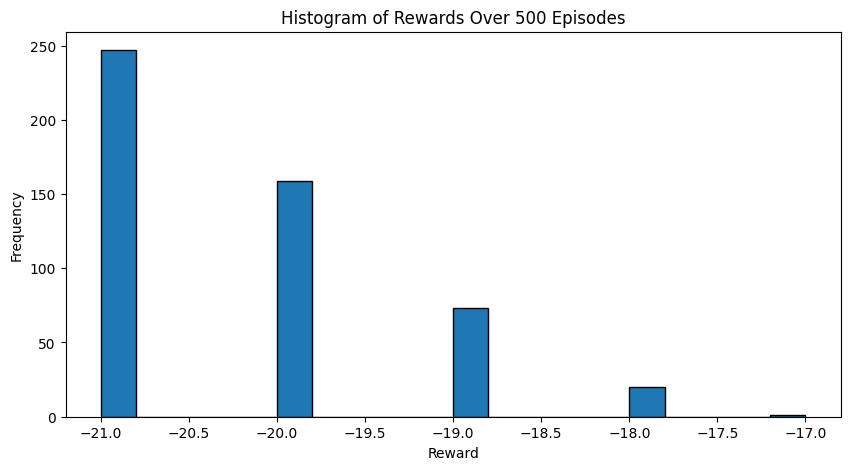

In [6]:
evaluate(pong_baseline)